In [72]:
import sys

base_path = '/tf/eipi10/qbz95'
sys.path.append(base_path)

from qbz95 import config
import pandas as pd
config = config.get_config('jupyter')
pd.set_option('display.width', 1000)

%matplotlib inline

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

# #当module有新的方法的时候，需要运行下面方法。
# %reload_ext autoreload


INFO:root:deployment = local_wechat
INFO:root:base_path = /home/grid/eipi10/qbz95/qbz95
INFO:root:data_path = /home/grid/eipi10/qbz95/data
INFO:root:deployment = jupyter
INFO:root:base_path = /tf/eipi10/qbz95/qbz95
INFO:root:data_path = /tf/eipi10/qbz95/data


In [56]:
import os
import pickle
import tarfile
import six.moves.urllib as urllib

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

def download_and_extract(target_path, source_url="https://www.cs.toronto.edu/~kriz", http_proxy=None):
    if http_proxy is not None:
        proxy_handler = urllib.request.ProxyHandler({'http': http_proxy, 'https': http_proxy})
        opener = urllib.request.build_opener(proxy_handler)
    else:
        opener = urllib.request.build_opener()

    urllib.request.install_opener(opener)

    def maybe_download(file_name):
        if not os.path.exists(target_path):
            os.mkdir(target_path)
        file_path = os.path.join(target_path, file_name)
        if not os.path.exists(file_path):
            source_file_url = os.path.join(source_url, file_name)
            logging.info(source_file_url)
            filepath, _ = urllib.request.urlretrieve(source_file_url, file_path)
            statinfo = os.stat(filepath)
            logging.info('Successfully downloaded {} {} bytes.'.format(file_name, statinfo.st_size))
        return file_path
    
    tar_gz_file = 'cifar-10-python.tar.gz'
    data_path= maybe_download(tar_gz_file)
    
    # extract the tar.gz file
    extract_path = os.path.join(target_path, "cifar-10-batches-py")
    logging.info("extract {} to {}".format(tar_gz_file, extract_path))
    with tarfile.open(data_path, 'r:gz') as tar:        
        tar.extractall(path=target_path)
    return extract_path

local_path = os.path.join('.', 'data/cifar10')
data_path = download_and_extract(local_path)

INFO:root:extract cifar-10-python.tar.gz to ./data/cifar10/cifar-10-batches-py


In [80]:
def extract_data_label(files):
    data = []
    label = []    
    for file in files:
        with open(file, 'rb') as fo:
            entry = pickle.load(fo, encoding='latin1')
        print(entry.keys())
        data.append(entry['data'])
        label.extend(entry['labels'])
 
    data = np.vstack(data)
    data = data.reshape(-1, 3, 32, 32)
    data = data.transpose((0, 2, 3, 1))   
    label = np.array(label)
    return data, label

train_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
train_files = [ os.path.join(data_path, file)  for file in train_files]
test_files = [ os.path.join(data_path, 'test_batch')]

train_data, train_label = extract_data_label(train_files)
test_data, test_label = extract_data_label(test_files)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)
print(np.max(train_data[0][0:11000]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)
255


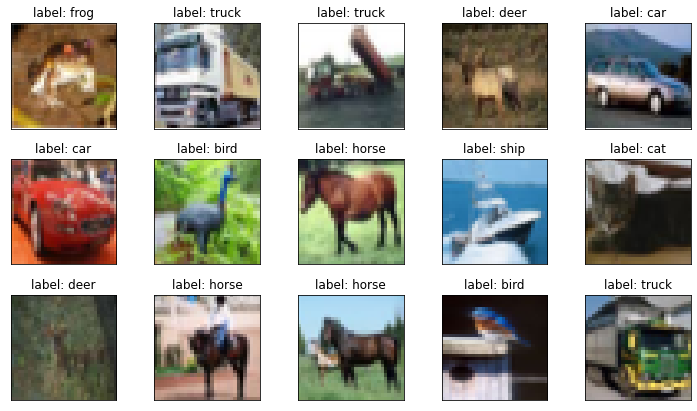

In [79]:
plt.rcParams['figure.figsize'] = (10.0, 6.0) 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for i in range(15):
    plt.subplot(3,5,i+1)
    plt.tight_layout()
    plt.imshow(train_data[i])
    plt.title("label: {}".format(classes[train_label[i]]))
    plt.xticks([])
    plt.yticks([])
    

In [10]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets


class LeNet(nn.Module):
    def __init__(self, in_dim=1, n_class=10):
        super(LeNet, self).__init__()    

        self.conv1 = nn.Conv2d(in_dim, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_class)        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
def train(net, criterion, trainloader, optimizer, epoches=5, use_cuda=False):
    cuda_run = None
    if use_cuda and  torch.cuda.is_available():
        cuda_run = True
        net = net.cuda()
        criterion = criterion.cuda()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epoches):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data            
            if cuda_run:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0




In [12]:
                
print("-"*50 + "\n创建模型：")    
net = LeNet()
print(net)

print("-"*50 + "\n显示参数：")
# 由于存在bias，所以每一层都有两个参数张量，共有10个参数张量。
params = list(net.parameters())
print(len(params))
for param in params:
    print(param.size())                
                
print("-"*50 + "\n获取数据：")
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



print("-"*50 + "\n训练模型：")

--------------------------------------------------
创建模型：
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
--------------------------------------------------
显示参数：
10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
--------------------------------------------------
获取数据：


100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
--------------------------------------------------
训练模型：


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [34]:



model = Cnn(1, 10)  # 图片大小是28x28,输入深度是1，最终输出的10类
use_gpu = torch.cuda.is_available()  # 判断是否有GPU加速
if use_gpu:
    model = model.cuda()

# 定义loss和optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

#logger = Logger('./logs')
# 开始训练
for epoch in range(num_epoches):
    print('epoch {}'.format(epoch + 1))      # .format为输出格式，formet括号里的即为左边花括号的输出
    print('*' * 10)
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader, 1):
        img, label = data
        # cuda
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        img = Variable(img)
        label = Variable(label)
        # 向前传播
        out = model(img)
        loss = criterion(out, label)
        running_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        accuracy = (pred == label).float().mean()
        running_acc += num_correct.item()
        # 向后传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        """
        # ========================= Log ======================
        step = epoch * len(train_loader) + i
        # (1) Log the scalar values
        info = {'loss': loss.data[0], 'accuracy': accuracy.data[0]}

        for tag, value in info.items():
            logger.scalar_summary(tag, value, step)

        # (2) Log values and gradients of the parameters (histogram)
        for tag, value in model.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, to_np(value), step)
            logger.histo_summary(tag + '/grad', to_np(value.grad), step)

        # (3) Log the images
        info = {'images': to_np(img.view(-1, 28, 28)[:10])}

        for tag, images in info.items():
            logger.image_summary(tag, images, step)
        if i % 300 == 0:
            print('[{}/{}] Loss: {:.6f}, Acc: {:.6f}'.format(
                epoch + 1, num_epoches, running_loss / (batch_size * i),
                running_acc / (batch_size * i)))
        """
    print('Finish {} epoch, Loss: {:.6f}, Acc: {:.6f}'.format(
        epoch + 1, running_loss / (len(train_dataset)), running_acc / (len(train_dataset))))
    model.eval()
    eval_loss = 0
    eval_acc = 0
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = Variable(img, volatile=True).cuda()
            label = Variable(label, volatile=True).cuda()
        else:
            img = Variable(img, volatile=True)
            label = Variable(label, volatile=True)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
        test_dataset)), eval_acc / (len(test_dataset))))
    print()

# 保存模型
torch.save(model.state_dict(), './cnn.pth')

'2.2.1'

In [ ]:

# 定义超参数
batch_size = 128        # 批的大小
learning_rate = 1e-2    # 学习率
num_epoches = 20        # 遍历训练集的次数


# 下载训练集 MNIST 手写数字训练集
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
